<a href="https://colab.research.google.com/github/ronald-hk-chung/ComputerVision/blob/main/RCNN_implimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to R-CNN Model

Region based Convolutional Neural Networks (R-CNNs) were initially presented by Girshick et. al. in their paper titled <a href="https://arxiv.org/abs/1311.2524">“Rich feature hierarchies for accurate object detection and semantic segmentation”</a> in 2013. R-CNN is a multi-stage object detection models which became the starting point for faster and more sophisticated variants in following years.

The R-CNN model is made up of four main components:

*   **Region Proposal:**
The extraction of regions of interest is the first and foremost step in this pipeline. The R-CNN model makes use of an algorithm called Selective Search for region proposal. Selective Search is a greedy search algorithm proposed by Uijlings et. al. in 2012. Without going into too many details, selective search makes use of a bottoms-up multi-scale iterative approach to identify ROIs. In every iteration the algorithm groups similar regions until the whole image is a single region. Similarity between regions is calculated based on color, texture, brightness etc. Selective search generates a lot of false positive (background) ROIs but has a high recall. The list of ROIs is passed onto the next step for processing.
*   **Feature Extraction:**
The R-CNN network makes use of pre-trained CNNs such as VGGs or ResNets for extracting features from each of the ROIs identified in the previous step. Before the regions/crops are passed as inputs to the pre-trained network these are reshaped or warped to the required dimensions (each pretrained network requires inputs in specific dimensions only). The pre-trained network is used without the final classification layer. The output of this stage is a long list of tensors, one for each ROI from the previous stage.
*   **Classification Head:**
The original R-CNN paper made use of Support Vector Machines (SVMs) as the classifier to identify the class of object in the ROI. SVM is a traditional supervised algorithm widely used for classification purposes. The output from this step is a classification label for every ROI.
*   **Regression Head:**
This module takes care of the localization aspect of the object detection task. As discussed in the previous section, bounding boxes can be uniquely identified using 4 coordinates (top-left (x, y) coordinates along with width and height of the box). The regressor outputs these 4 values for every ROI.


Below shows the pipeline of the model

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*_bYL-bCFWVilXe0DEViGmw.png">

The R-CNN model was slow, but it provided a good base for object detection models to come down the line. The computationally expensive and slow feature extraction step was mainly addressed in the Fast R-CNN implementation.


### Notebook setup

In [ ]:
# Import TorchStep
!git clone https://github.com/ronald-hk-chung/TorchStep
!sh TorchStep/config.sh
!pip install -q kaggle

Cloning into 'TorchStep'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 51 (delta 23), reused 44 (delta 16), pack-reused 0
Receiving objects: 100% (51/51), 16.93 KiB | 8.46 MiB/s, done.
Resolving deltas: 100% (23/23), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 19.7 MB/s eta 0:00:00


In [ ]:
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from TorchStep.vision_utils import SelectiveSearch, show_image
from TorchStep.engine import TSEngine
from PIL import Image
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import cv2

## Download Dataset - Google Open Image v6 dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
from google.colab import files
# files.upload() # upload kaggle.json
shutil.copy2('drive/MyDrive/kaggle/kaggle.json','kaggle.json')
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

-rw------- 1 root root 69 Jan 19 13:52 kaggle.json


In [ ]:
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

 99% 364M/367M [00:10<00:00, 38.2MB/s]
100% 367M/367M [00:10<00:00, 37.2MB/s]


## Preparing the dataset
1. Fetching each image and its corresponding class and bounding box values
2. Fetching the region proposals within each image, their corresponding IoU, and the delta by which the region proposal is to be corrected with respect to the ground truth
3. Assigning numeric lables for each class (where we have an additional background class *besides the bus and truck classes) where IoU with the ground thruth bounding box is below a threshold
4. Resizing each region proposal to a common size in order to pass them to a network

By the end, we will ahve resied crops of region proposals, along wiht assigning the ground truth class to each region proposal, and calculated the offset of the region proposal in relation to the ground truth bounding box

In [ ]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')

In [ ]:
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


`XMin`, `XMax`, `YMin`, `YMax` correspond to the ground truth of the bounding box of the image. `LabelName` provides the class of images

In [ ]:
class OpenImages(Dataset):
  def __init__(self, df, image_folder):
    self.root = image_folder
    self.df = df
    self.unique_images = self.df['ImageID'].unique() #image can contain multiple objects
  def __len__(self):
    return len(self.unique_images)
  def __getitem__(self, idx):
    image_id = self.unique_images[idx]
    image_path = f'{self.root}/{image_id}.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:,:,::-1]
    h, w, _ = image.shape
    df = self.df[self.df['ImageID']==image_id]
    boxes = (df[['XMin','YMin', 'XMax', 'YMax']] * np.array([w, h, w, h])).astype(np.uint16).values.tolist()
    classes = df['LabelName'].values.tolist()
    return image, boxes, classes, image_path

ds = OpenImages(df=DF_RAW, image_folder=IMAGE_ROOT)

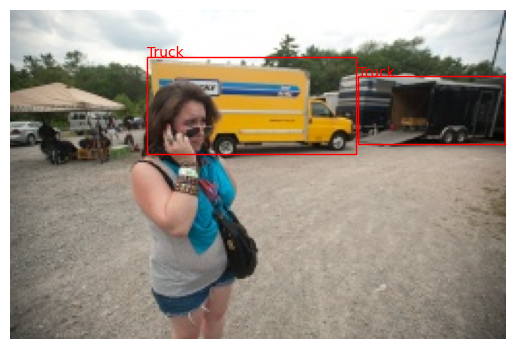

In [ ]:
img, bbs, labels, path = ds[1]
show_image(img=img, bbs=bbs, bbs_label=labels, bbs_format='XYXY', color='r')

## Selective Search
Referece: http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

31


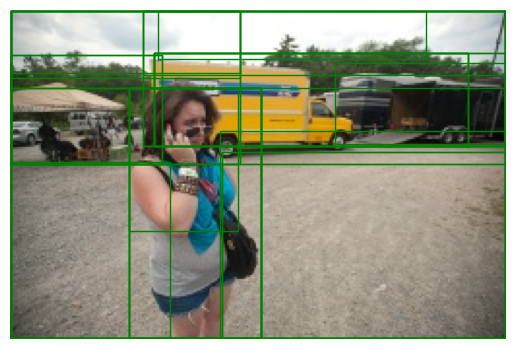

In [ ]:
# Using TorchStep.vision_utils.SelectiveSearch
img_search = SelectiveSearch(img=img, scale=200, min_size=100)
candidates = img_search.search(size_thresold=0.05, format='XYWH')
print(len(candidates))
show_image(img=img, bbs=candidates, bbs_format='XYWH', color='g')

## Define IOU function

Intersection over Union *IoU* is used to measure the accuracy of bounding box prediction.

*Intersection* measures how overalapping the predicted and actual bounding boxes are, while *Union* measures the overall space possible for overlap. *IoU* is the ratio of the overlapping region between the two bounding boxes over the combined region of both the bounding boxes

<img src='https://miro.medium.com/v2/resize:fit:640/format:webp/1*r0o3vX-x979Q84_lbJWS_g.jpeg'>

In [ ]:
def extract_iou(boxA: list,
            boxB: list,
            epsilon: float = 1e-5) -> float:
  """Calculate Intersection of Unions

  Args:
    boxA [list]: bounding box in format of 'XYXY'
    boxB [list]: bounding box in format of 'XYXY'
    epsilon [float]: smooth factor to avoid division by 0, default o 1e-5

  Return:
    iou [float]: intersection of unions
  """
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  width = (x2- x1)
  height = (y2 - y1)
  if width < 0 and height < 0:
    return 0.0
  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap
  iou = area_overlap / (area_combined + epsilon) # smooth devision to avoid 0/0
  return iou

## Preparing region proposals and the ground truth of offset

Creating the input and output values correspond to R-CNN model:

- input constitutes the candidates that are extracted using the *Selective Search* using selectivesearch algo from `TorchStep.vision_utils.SelectiveSearch` (refer to https://github.com/ronald-hk-chung/ComputerVision/blob/main/selective_search_algo.ipynb)

- output constitutes the class corresponding to candidates and the offset of the candidate with respect to the bounding box it overlaps and most with if the candidate contains an object

Initialise empty lists to store file paths (FPATHS), ground thuth bounding boxes (GTBBS), classes (CLSS) of objects, the delta offset of a bounding box with region proposals (DELTAS), region proposal locations (ROIS), and the IoU of region proposals with ground thruths (IOUS)

In [ ]:
data = []
N = 500
pbar = tqdm(total = N)
for ix, (im, bbs, labels, fpath) in enumerate(ds):
  if(ix==N):
      break
  # Extract candidates from each image in absolute pixel values
  H, W, _ = im.shape
  # candidates = extract_candidates(im)
  # convert the extracted regions coordinates from XYWH into XYXY
  # candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
  img_search = SelectiveSearch(img=im, scale=200, min_size=100)
  candidates = img_search.search(size_thresold=0.05, format='XYXY')


  # Initialise data_dict to hold ious, rois, clss and delta
  data_dict = {}
  rois, clss, deltas = [], [], []

  # Calculate ious comparing candidates to bbs (ground truth)
  ious = np.array([[extract_iou(candidate, bb) for candidate in candidates] for bb in bbs]).T

  for jx, candidate in enumerate(candidates):
    cx1,cy1,cx2,cy2 = candidate
    candidate_ious = ious[jx] # Get candidate ious
    # Find the index of candidate that has the highest IoU and correponding gound truth (best_bb)
    best_iou_index = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_index]
    best_bb = x1, y1, x2, y2 = bbs[best_iou_index]
    # If IoU (best_iou) is grater than a thresold(0.3), assign label of class, otherwise assign 'background'
    clss.append(labels[best_iou_index]) if best_iou > 0.3 else clss.append('Background')
    # Fetch offset needed (deltas) to transform current proposal into the candidate that is the best region proposal (best_bb)
    delta = np.array([x1-cx1, y1-cy1, x2-cx2, y2-cy2]) / np.array([W,H,W,H])
    deltas.append(delta)
    rois.append(candidate / np.array([W,H,W,H]))

  # put fpath, ious, rois, clss, deltas and bbs(as gtbbs) in data_dict and append to data
  data_dict['fpaths'] = fpath
  data_dict['ious'] = ious # intersection of unions result
  data_dict['rois'] = rois # regional proposal locations
  data_dict['clss'] = clss # class of bounding box
  data_dict['deltas'] = deltas # offset of ground_truth bounding box - candidate bounding box relative to image size
  data_dict['gtbbs'] = bbs # ground truth bounding box
  data.append(data_dict)
  pbar.update(1)
pbar.close()

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# Convert clss into their corresponding indices
# background 0, Bus 1, Truck 2
classes = sorted(set([item for data_dict in data for item in data_dict['clss']]))
label2target = {k : v for v, k in enumerate(classes)}
target2label = {v : k for k, v in label2target.items()}
print(label2target)
print(target2label)

{'Background': 0, 'Bus': 1, 'Truck': 2}
{0: 'Background', 1: 'Bus', 2: 'Truck'}


In [ ]:
# # savedown data into rcnn_data.pt
import pickle
with open('drive/MyDrive/CV/rcnn_data.pkl', 'wb') as f:
  pickle.dump(data, f)
# with open('drive/MyDrive/CV/rcnn_data.pkl', 'rb') as f:
#   data = pickle.load(f)

## Define dataset for RCNN

In [ ]:
import torch
from torchvision.transforms import v2 as T
transforms = T.Compose([T.ToImage(),
                        T.ToDtype(torch.float32, scale=True),
                        T.Resize(size=(224, 224), antialias=True),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)])

In [ ]:
class RNNDataset(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    fpath = self.data[idx]['fpaths']
    image = cv2.imread(fpath, cv2.IMREAD_COLOR)[:,:,::-1]
    H, W, C = image.shape
    sh = np.array([W, H, W, H])
    gtbbs = self.data[idx]['gtbbs']
    rois = self.data[idx]['rois']
    bbs = (np.array(rois) * sh).astype(np.uint16)
    labels = self.data[idx]['clss']
    deltas = self.data[idx]['deltas']
    crops = [image[y1:y2, x1:x2] for (x1, y1, x2, y2) in bbs]
    return image, crops, bbs, labels, deltas, gtbbs, fpath
  def collate_fn(self, batch):
    input = []
    rois = []
    rixs = []
    labels = []
    deltas = []
    for idx in range(len(batch)):
      image, image_crops, image_bbs, image_labels, image_deltas, image_gtbbs, image_fpath = batch[idx]
      input += [transforms(crop.copy()) for crop in image_crops]
      labels += [label2target[c] for c in image_labels]
      deltas += image_deltas
    input = torch.stack(input, dim=0)
    labels = torch.Tensor(np.array(labels)).long()
    deltas = torch.Tensor(np.array(deltas)).float()
    return input, labels, deltas

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_valid = train_test_split(data, test_size=0.1)

train_ds = RNNDataset(data=data_train)
valid_ds = RNNDataset(data=data_valid)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=2,
                      collate_fn=train_ds.collate_fn,
                      shuffle=True,
                      drop_last=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=2,
                      collate_fn=valid_ds.collate_fn,
                      shuffle=False,
                      drop_last=True)

## Modify vgg16 classifier that can predict both the class of region proposal and the offset corresponding to it in order to draw a tight bounding box around the object in teh image

1. Define VGG backbone
2. Fetch the features post passing the normalized crop through a pretrained model
3. Attach a linear layer with sigmoid activation to the VGG backbone to predict the class corresponding to the regional proposal
4. Attach an additional linear layer to predict the four bounding box offsets
5. Define the loss calculations for each of the two outputs (one to predict classa nd the other to predict the four bounding box offsets)
6. Train the model that predicts both the class of region proposal and the four bounding box offsets

In [ ]:
from TorchStep.vision_utils import get_pretrained_model
vgg, tfms_vgg, rtfms_vgg = get_pretrained_model(name='vgg16', pretrained_weights='VGG16_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 323MB/s]


In [ ]:
# Define model from vgg backbone
# Attach linear layer predict the class
# Attach additional linear layer to predict 4 bouding box offsets
class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim = 25088
    self.backbone = nn.Sequential(*list(vgg.children())[:-1],
                                  nn.Flatten())
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(nn.Linear(feature_dim, 512),
                              nn.ReLU(),
                              nn.Linear(512, 4),
                              nn.Tanh())
  def forward(self, input):
    feature = self.backbone(input)
    cls_score = self.cls_score(feature)
    bbox = self.bbox(feature)
    return cls_score, bbox

rcnn = RCNN()

In [ ]:
class RCNNLoss:
  def __init__(self):
    self.detection_loss = nn.CrossEntropyLoss()
    self.regression_loss = nn.L1Loss()
  def __call__(self, y_logits, y):
    detection_loss = self.detection_loss(y_logits[0], y[0])
    ixs = torch.where(y[0] != 0)
    if len(ixs) > 0:
      regression_loss = self.regression_loss(y_logits[1][ixs], y[1][ixs])
      if torch.isnan(regression_loss):
        regression_loss = 0
    else:
      regression_loss = 0
    return detection_loss + 10 * regression_loss

loss_fn = RCNNLoss()

In [ ]:
class RCNNMetric:
  def __init__(self):
    self.detection_loss = nn.CrossEntropyLoss()
    self.regression_loss = nn.L1Loss()
  def __call__(self, y_logits, y):
    detection_loss = self.detection_loss(y_logits[0], y[0]).cpu().detach().numpy()
    detection_acc = sum(y_logits[0].argmax(dim=1) == y[0]).item() / len(y[0])
    ixs = torch.where(y[0] != 0)
    if len(ixs) > 0:
      regression_loss = self.regression_loss(y_logits[1][ixs], y[1][ixs]).cpu().detach().numpy()
      if np.isnan(regression_loss):
        regression_loss = 0
    else:
      regression_loss = 0
    return detection_loss, detection_acc, (0 if np.isnan(regression_loss) else regression_loss)

metric_fn = RCNNMetric()

In [ ]:
RCNNDetector = TSEngine(model=rcnn,
                        optim=(torch.optim.SGD, {'lr': 1e-3}),
                        loss_fn=loss_fn,
                        metric_fn=metric_fn,
                        train_dataloader=train_dl,
                        valid_dataloader=valid_dl)

In [ ]:
RCNNDetector.freeze(['backbone'])

In [ ]:
RCNNDetector.train(5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 1.84 | valid_loss: 1.56 | train_metric: [0.572 0.779 0.127] | valid_metric: [0.517 0.808 0.104] 
Epoch: 2 | LR: 1.0E-03 | train_loss: 1.225 | valid_loss: 1.517 | train_metric: [0.355 0.86  0.087] | valid_metric: [0.527 0.812 0.099] 
Epoch: 3 | LR: 1.0E-03 | train_loss: 0.951 | valid_loss: 1.517 | train_metric: [0.278 0.898 0.067] | valid_metric: [0.561 0.816 0.096] 
Epoch: 4 | LR: 1.0E-03 | train_loss: 0.809 | valid_loss: 1.454 | train_metric: [0.228 0.924 0.058] | valid_metric: [0.515 0.819 0.094] 
Epoch: 5 | LR: 1.0E-03 | train_loss: 0.713 | valid_loss: 1.438 | train_metric: [0.197 0.936 0.052] | valid_metric: [0.518 0.837 0.092] 


In [ ]:
# Saving Checkpoint
RCNNDetector.save_checkpoint('drive/MyDrive/CV/RCNNDetector.pt')

## Predict on a new image
To predict and draw bounding boxes around objects and the corresponding class of object within the predicted bounding box on new image

1. Extract region proposals from new image
2. Resize and normalize each crop
3. Feed-forward the processed crops to make predictions of class and the offsets
4. Perform non-max suppression to fetch only those boxes that have the highest confidence

## Non-max suppression

Non-supression is used to solve the problem where multiple region proposals are generated and significantly overlap one another.

*Non-max* refers to the boxes that do not contain the highest probability of containing an object, and suppression refers to us discarding those boxes that do not contain the highest probabilities of containing an object. In non-max suppression, we identify the bounding boxes that has the highest probability and discard all the other bounding boxes that have an IoU greater than a certain threshold with the box containing the highest probability of contianing an object

In Pytorch, non-max suppression is performed using the `nms` function in the `torchvision.ops` module. The `nms` function takes the bounding box coordinates, the confidence of the object in teh boudning box, and the threshold of IoU across bounding boxes, to identify the boudning boxes to be retained.

In [ ]:
def rcnn_inference(fname: str):
  img = cv2.imread(fname, cv2.IMREAD_COLOR)[:,:,::-1]

  img_search = SelectiveSearch(img=img, scale=200, min_size=100)
  candidates = img_search.search(size_thresold=0.05, format='XYXY')

  input=[]
  for candidate in candidates:
    x1, y1, x2, y2 = candidate
    crop = img[y1:y2, x1:x2]
    input.append(transforms(crop.copy()))
  input = torch.stack(input, dim=0)
  # Make predictions using model to get probs and deltas
  probs, deltas = RCNNDetector.predict(input)
  # Turn probs into probabilities of class using softmax and get max prob clss
  probs = torch.nn.functional.softmax(probs, -1)
  confs, clss = torch.max(probs, -1)
  # Turn tensor into numpy for filtering operation for non-background indices
  candidates = np.array(candidates)
  confs, clss, probs, deltas,  = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
  # Filter out Background clss
  nb_idx = clss != label2target['Background']
  confs, clss, probs, deltas, candidates = [tensor[nb_idx] for tensor in [confs, clss, probs, deltas, candidates]]
  # For bounding box (bbs) with deltas and candidates
  bbs = (candidates + deltas).astype(np.uint16)
  # Perform non-max suppression and perform filtering on nms_idx https://pytorch.org/vision/main/generated/torchvision.ops.nms.html
  nms_idx = nms(boxes=torch.tensor(bbs.astype(np.float32)),
                scores=torch.tensor(confs),
                iou_threshold=0.05)
  confs, clss, probs, deltas, candidates, bbs = [tensor[nms_idx] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

  if len(nms_idx) == 1:
    confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  if len(confs) > 0:
    best_pred = np.argmax(confs)
    best_conf = np.max(confs)
    best_bbs = bbs[best_pred]
    x1, y1, x2, y2 = best_bbs
    show_image(img=img, bbs=bbs, bbs_label=[target2label[clss[best_pred]]], bbs_format='XYXY', color='r')
    return best_bbs, target2label[clss[best_pred]],best_conf
  else:
    show_image(img=img)
    return (0,0,224,224), 'Background', 0


In [ ]:
import requests
url = 'https://fft-keybuses.b-cdn.net/sites/busesmag/files/styles/article_body/public/imported/2021-01-12/img_40-2.jpg?itok=kQSKw6Gv'
with open('bus.jpg', 'wb') as f:
  f.write(requests.get(url).content)

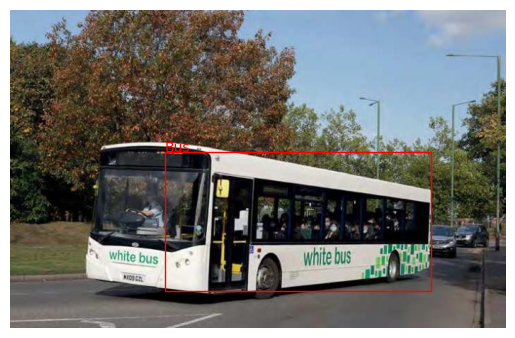

(array([218, 200, 594, 396], dtype=uint16), 'Bus', 0.9999993)

In [ ]:
rcnn_inference('bus.jpg')

In [ ]:
url='https://cf-images.us-east-1.prod.boltdns.net/v1/static/648728607001/b3aaad19-0e1c-48ce-913c-da41bff917fa/1336f83a-e039-4fb2-a14c-5a793486361d/1280x720/match/image.jpg'
with open('truck.jpg', 'wb') as f:
  f.write(requests.get(url).content)

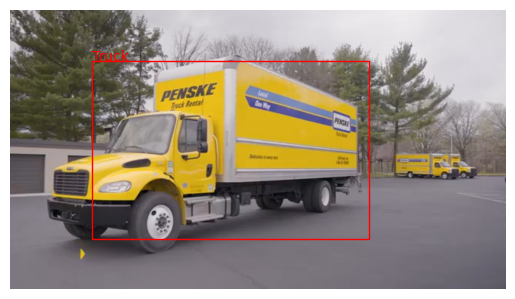

(array([210, 130, 927, 590], dtype=uint16), 'Truck', 0.9999707)

In [ ]:
rcnn_inference('truck.jpg')